Import the necessary modules

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import fredapi as fa
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf
import pickle
import streamlit as st
import warnings
warnings.filterwarnings('ignore')

In [3]:
#import the API key
fred = fa.Fred(st.secrets["fred"]["API_KEY"])

In [4]:
#retrieve the data using the get_series() method and convert it to a dataframe
df = fred.get_series('RSXFS').to_frame(name='RSXFS').reset_index()
df.head()

,index,RSXFS
0,1992-01-01,142419.0
1,1992-02-01,142584.0
2,1992-03-01,142120.0
3,1992-04-01,143659.0
4,1992-05-01,144239.0


In [5]:
#to rename the index column to date
df = df.rename(columns={'index':'date'})
df.head() 

,date,RSXFS
0,1992-01-01,142419.0
1,1992-02-01,142584.0
2,1992-03-01,142120.0
3,1992-04-01,143659.0
4,1992-05-01,144239.0


Data Preprocessing

In [6]:
#check for missing values - conlusion: there are no missing values in the data 
df.isnull().sum()

date     0
RSXFS    0
dtype: int64

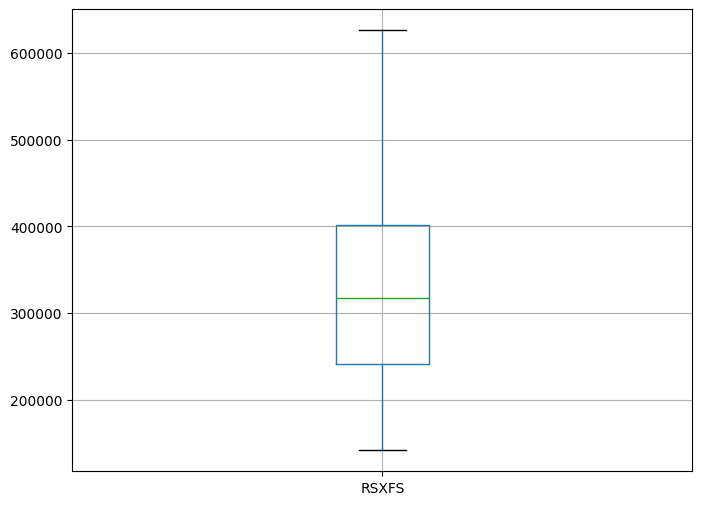

In [7]:
#to visualize outliers using a boxplot - conclusion: there are no outliers in the data
plt.figure(figsize=(8,6))
df.boxplot() 
plt.show()

In [8]:
#to check for duplicates in the index column - conclusion: no duplicates in the index column
df['date'].duplicated().sum()

0

In [9]:
#to check for duplicates in the RSXFS column - conclusion: no duplicates in the RSXFS column
df['RSXFS'].duplicated().sum()

0

In [10]:
#to get the datatypes for our columns - our date column is already converted to a datetime object
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    400 non-null    datetime64[ns]
 1   RSXFS   400 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.4 KB


In [11]:
#set the date column as the index of the dataframe to enable resampling and rolling operations (moving statistics like averages, sums) for a sliding time window
df.set_index('date', inplace=True)
df.head()

,RSXFS
date,
1992-01-01,142419.0
1992-02-01,142584.0
1992-03-01,142120.0
1992-04-01,143659.0
1992-05-01,144239.0


In [12]:
#perform upsampling by breaking the monthly date column to bi-weekly to get the retail sales made every two weeks from the sector. 

#resample monthly data to biweekly
df = df.resample('MS').mean()

df_biweekly = df.resample('14D').interpolate(method='linear').ffill()

df_biweekly.tail()

,RSXFS
date,
2025-01-29,615973.0
2025-02-12,615973.0
2025-02-26,615973.0
2025-03-12,615973.0
2025-03-26,615973.0


In [13]:
#to check for missing values in the data 
df_biweekly.isnull().sum() 

RSXFS    0
dtype: int64

In [14]:
#drop the missing values
# df_biweekly.dropna(inplace=True)

In [15]:
#visualize our dataset with plotly for interactivity 

#create a subplot of 1 row, 2 columns
fig = make_subplots(rows = 1, cols = 2, subplot_titles = ('Before Upsampling', 'After Upsampling'))

# a) plot for before upsampling 

fig.add_trace(
    go.Scatter(
        x = df.index,
        y = df[df.columns[0]],
        mode = 'lines',
        line = dict(color = 'steelblue')
    ),
    row = 1, col = 1
)

# b) plot after upsampling

fig.add_trace(
    go.Scatter(
        x = df_biweekly.index,
        y = df_biweekly[df_biweekly.columns[0]],
        mode = 'lines',
        line = dict(color = 'red')
    ),
    row = 1, col = 2
)

fig.update_layout(
    width = 1000,
    height = 600,
    xaxis_title = 'Date',
    yaxis_title = 'Retail Sales in Millions (USD)',
    title_text = 'Retail Sales Comparison: Before and After Upsampling',
    showlegend = False
)

fig.update_xaxes(title_text = 'Date', row = 1, col = 1)
fig.update_yaxes(title_text = 'Retail Sales in Millions (USD)', row = 1, col = 1)

fig.update_xaxes(title_text = 'Date', row = 1, col = 2)
fig.update_yaxes(title_text = 'Retail Sales in Millions (USD)', row = 1, col = 2)

fig.show()

Conclusion: 

- From the above graphs, our series doesn't satisfy the required stationarity assumption of time series just yet. It shows an exponential trend whereby the mean is a function of time.

- Why an exponential trend? The assumption is that as the Retail and Food Services sector continued growing in the United States, the overall sales also grew with each month since it got more popular across its growing population over the years.  

To remove trend and seasonality using decomposition. Time series decomposition splits the series into three component series namely:

- Seasonal: Patterns that repeat within a fixed period.

- Trend: The underlying trend of the metric.

- Random (noise, irregular or remainder): The residual of the original time series after the seasonal and trend series are removed.  

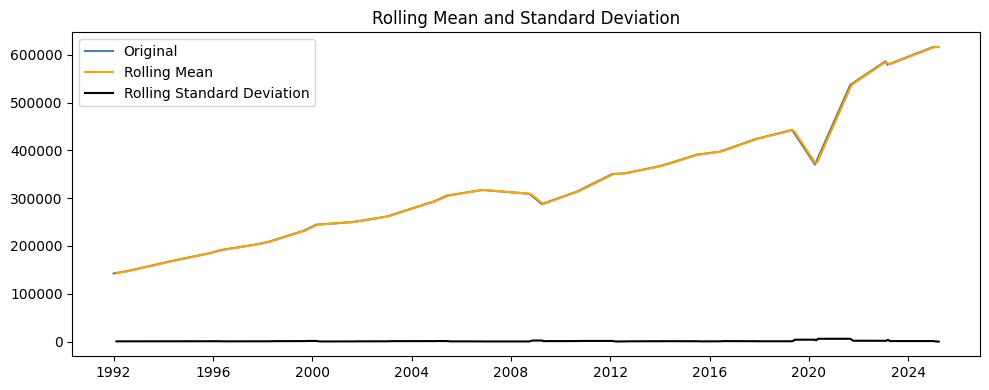

Output of the Dickey-Fuller Test: 

Test Statistic                  -0.017706
p-value                          0.957043
#Lags Used                       3.000000
Number of Observations Used    864.000000
Critical Value (1%)             -3.437941
Critical Value (5%)             -2.864891
Critical Value (10%)            -2.568554
dtype: float64


In [16]:
def stationarity_check(df_biweekly):
    
    #get the rolling statistics
    roll_mean = df_biweekly.rolling(window = 4, center = False).mean() 
    roll_std = df_biweekly.rolling(window = 4, center = False).std()

    #perform the Dickey-Fuller test to assess stationarity
    df_test = adfuller(df_biweekly)

    #plot the rolling statistics
    fig = plt.figure(figsize=(10,4))
    original = plt.plot(df_biweekly, color = 'steelblue', label = 'Original')
    mean = plt.plot(roll_mean, color = 'orange', label = 'Rolling Mean')
    std = plt.plot(roll_std, color = 'black', label = 'Rolling Standard Deviation')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.tight_layout()
    plt.show(block = False)

    #print the results of the Dickey-Fuller test
    print('Output of the Dickey-Fuller Test: \n')

    df_output = pd.Series(df_test[0:4], index = ['Test Statistic','p-value','#Lags Used', 'Number of Observations Used'])

    for key, value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value

    print(df_output)

    return None

stationarity_check(df_biweekly['RSXFS'])

Conclusion: 

- The orange line represents the rolling mean while the black line represents the rolling standard deviation. 

- The mean is not constant over time, meaning we can reaffirm our conclusion that the time series is not stationary based on the two statistics.  

- After implementing the Dickey-Fuller test to reaffirm non-stationarity in the data, since the test statistic (-0.018) is greater than the critical values at 1% (-3.44), 5% (-2.86) and 10% (-2.57), we fail to reject the null hypothesis and conclude that our time series is indeed not stationary.

Removing Stationarity using Time Series Decomposition

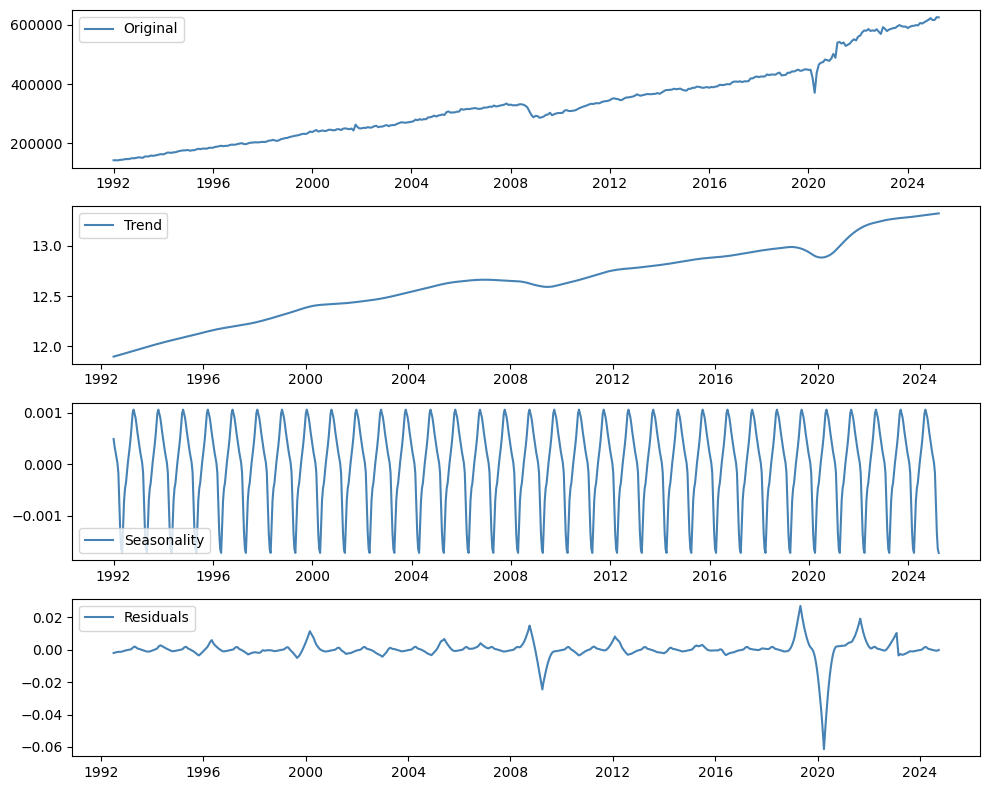

In [17]:
decomposition = seasonal_decompose(np.log(df_biweekly['RSXFS']), model='additive', period=26)

#get the trend, seasonality and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

#plot the components
plt.figure(figsize=(10,8))

plt.subplot(411)
plt.plot(df, label = 'Original', color = 'steelblue')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend, label = 'Trend', color = 'steelblue')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality', color = 'steelblue')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals', color = 'steelblue')
plt.legend(loc = 'best')

plt.tight_layout()
plt.show(block=False)


Interpretation:

a) For the original and trend plots: 

- It shows a steady growth from 1992 to around 2019, which indicates a long-term positive trend in the sector. 

- The growth then flattens slightly around 2008 to 2010 which is likely due to the global financial crisis around this time (which was brought about by easy credit and loose lending habits). 

- Borrowers with poor credit histories were being issued mortgages. These high-risk loans were then bundled into mortgage-backed securities and sold to investors, and as a result, spreading the riks throughout the financial system.

- It then picks up again after 2010.

- In 2020, there's a noticeable drop in sales followed by a fast recovery and sharp fluctuations. This is likely due to the COVID-19 pandemic which severly disrupted consumer behavior especially in retail and food services. The sharp spike after the fluctuation in sales could also be explained by recovery demand or stimulus effects.

- After 2021, the sales seem to take an upward trajectory, implying a strong rebound in consumer behavior. 

c) For the seasonal plot:

- Shows repeating cyclical patterns that occur at a regular frequency (yearly). The sales values rise and fall in a regular sinusoidal pattern.

- Its amplitude looks stable, suggesting the seasonal effect is consistent year after year. 

d) For the residual plot:

- The noise is mostly centered around 0, with higher variances being around 2008 and 2020 (possibly from the financial crisis in 2008 and COVID-19 pandemic respectively).

To check the stationarity of residuals using the Dickey-Fuller test:

In [18]:
residual.isnull().sum()

26

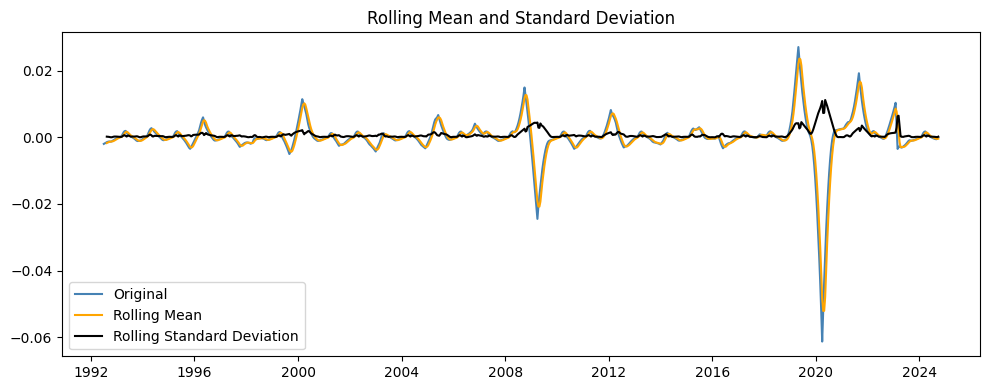

Output of the Dickey-Fuller Test: 

Test Statistic                -8.676781e+00
p-value                        4.394393e-14
#Lags Used                     3.000000e+00
Number of Observations Used    8.380000e+02
Critical Value (1%)           -3.438177e+00
Critical Value (5%)           -2.864995e+00
Critical Value (10%)          -2.568610e+00
dtype: float64


In [19]:
#drop the missing values from the residuals
log_decompose = residual
log_decompose.dropna(inplace=True)

stationarity_check(log_decompose)

Interpretation: 

- The above plot shows the mean line does not drift over time and the rolling standard deviation is flat, implying that trend and seasonality have been removed. 

- To support this, our test statistic from the Dickey-Fuller Test (-8.68) is now less than the critical values at 1% (-3.44), 5 (-2.86) and 10% (-2.57), we reject the null hypothesis and conclude that our time series is now stationary.

To check for outliers. I've decided to keep them since they mostly represent real-worls shocks, i.e. the 2008 economi recession and the COVID-19 pandemic

In [20]:
#check for outliers using the inter-quartile range method

Q1 = log_decompose.quantile(0.25)
Q3 = log_decompose.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = log_decompose[(log_decompose < lower_bound) | (log_decompose > upper_bound)]

print("Number of outliers:", len(outliers))


Number of outliers: 105


To check for Autocorrelation of residuals using the Autocorrelation Function Plot:

- Checks how each time series observation is related to it past or recent past. 

- The blue shaded region implies a 95% confidence interval. Bars outside this region are statistically sigificant autocorrelations. 

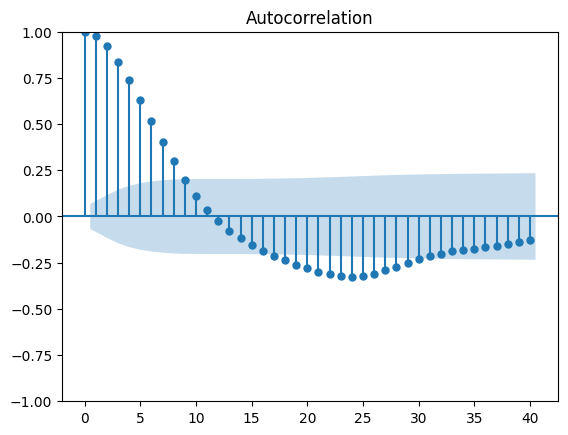

In [21]:
plot_acf(log_decompose, lags=40)
plt.show();

Interpretation:

- There is high autocorrelation at low lags. 

- Lag 1 is almost at 1.0 and the autocorrelation declines gradually, suggesting that the series is highly dependent on its recent past. 

- The autocorrelation declines slowly but remains statistically significant up to lag 40.

- The slow decline indicates a strong trend, meaning the series is not 100% stationary.

Modeling using SARIMAX

In [22]:
#split the data into 80% train and 20% test
series = df_biweekly['RSXFS']

split_index = int(len(series) * 0.8)
train = series.iloc[:split_index]
test = series.iloc[split_index:]

In [23]:
#use auto arima to find the best SARIMA parameters
# auto_model = auto_arima(
#     train,
#     seasonal = True, 
#     m = 26, #seasonal length for biweekly data 
#     error_action = 'ignore',
#     suppress_warnings = True,
#     stepwise = True,
#     trace = True
# )

# #display the best model
# print(auto_model.summary())

In [24]:
#use the best parameters in SARIMAX
model = SARIMAX(
    train,
    order = (1,1,1),
    seasonal_order = (1,1,1,12),
    enforce_stationarity = False,
    enforce_invertibility = False
)

result = model.fit()

print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              RSXFS   No. Observations:                  694
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4298.913
Date:                            Thu, 22 May 2025   AIC                           8607.826
Time:                                    22:42:08   BIC                           8630.340
Sample:                                01-01-1992   HQIC                          8616.548
                                     - 07-25-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9188      0.010     89.220      0.000       0.899       0.939
ma.L1          0.0937      0.022   

In [25]:
#to forecast
forecast = result.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

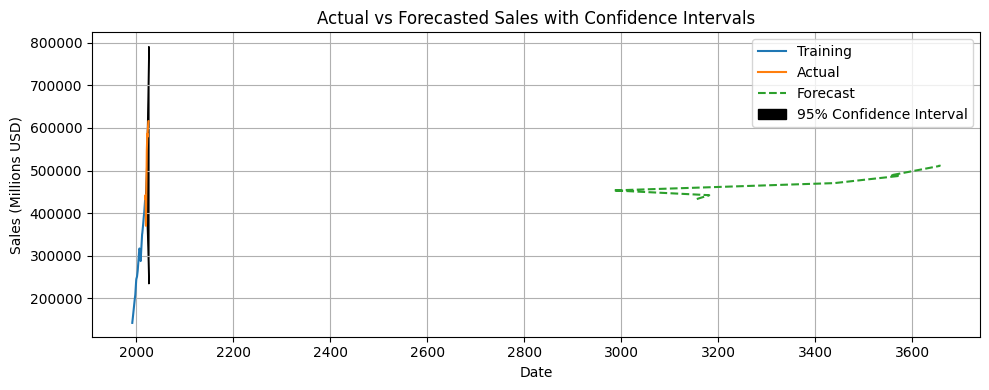

In [26]:
#compare the forecast vs actual
plt.figure(figsize=(10,4))
plt.plot(train.index, train, label = 'Training')
plt.plot(test.index, test, label = 'Actual')
plt.plot(test, forecast_mean, label = 'Forecast', linestyle = '--')
plt.fill_between(forecast_mean.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color = 'black', label = '95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales (Millions USD)')
plt.legend()
plt.grid(True)
plt.title('Actual vs Forecasted Sales with Confidence Intervals')
plt.tight_layout()
plt.show()

Using evaluation metrics (mean absolute error and mean squared error) to test the performance of my model:

In [27]:
mae = mean_absolute_error(test, forecast_mean)
rmse = mean_squared_error(test, forecast_mean, squared=False)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 63164.90
Root Mean Squared Error: 72982.16


Interpretation of the error metrics:

- Using the mean abslolute error, the model forecasting is off by about USD 63,000 on average. 

- Using Mean Absolute Percentage Error to explain by what percentage my model performance is off by:

In [28]:
mape = mean_absolute_percentage_error(test, forecast_mean)
print(f'MAPE: {mape:.2f}%')

MAPE: 0.12%


- This implies that my model performance is off by 0.12%. Since the relative error is less than 10%, this means that the model has an excellent forcasting accuracy.

- The model is making errors that are less than 1% of the actual sales values on average.

Save the model

In [29]:
with open('sarimax_model.pkl', 'wb') as f:
    pickle.dump(result, f)

with open('sarimax_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [30]:
#to preserve the fitted SARIMAXResultsWrapper to directly forecast later:
future_forecast = loaded_model.get_forecast(steps=12)